# Torch Runtime

In this tutorial, we introduce Torch Runtime, and show how to use it via the `TorchRuntimeClient` class in Qiskit Machine Learning.
Torch Runtime leverages Qiskit Runtime for 
hybrid quantum-classical machine learning based on a PyTorch `Module`. It allows training models or predicting the outputs with trained models significantly faster. We show how to use Torch RUntime with two simple examples for regression and classification tasks in the following.

## 1. Regression

First, we show how to use Torch Runtime via `TorchRuntimeClient` using the simple regression example. In the example, we will perform 
a regression task on a randomly generated dataset following a sin wave.

In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor, manual_seed, is_tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, Adam
from torch.utils.data import Dataset, DataLoader

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult


# Set seed for random generators
seed = 42
manual_seed(seed)
algorithm_globals.random_seed = seed

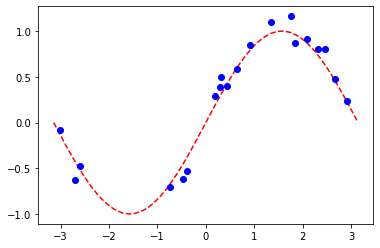

In [2]:
# Generate random dataset: Train
import matplotlib.pyplot as plt

np.random.seed(0)
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)
X = (ub - lb)*np.random.rand(num_samples, 1) + lb
y = f(X) + eps*(2*np.random.rand(num_samples, 1)-1)

plt.figure()
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), 'r--')
plt.plot(X, y, 'bo')
plt.show()


`TorchRuntimeClient` requires a PyTorch `DataLoader` as an input for training/predicting. For that purpose, we create a custom torch dataset class.

In [3]:
# Create custom torch dataset class
class TorchDataset(Dataset):

    """Map-style dataset"""
    def __init__(self, X, y):
        self.X = Tensor(X).float()
        self.y = Tensor(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        import torch
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X_i = self.X[idx]
        y_i = self.y[idx]

        # important: the dataset item must be returned as data,target
        return X_i, y_i

# Create a train loader
train_set = TorchDataset(X,y)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)

Create a PyTorch model, and set up an optimizer and a loss function as usual.

In [10]:
from qiskit.circuit import Parameter

# Construct simple feature map
param_x = Parameter('x')
feature_map = QuantumCircuit(1, name='fm')
feature_map.ry(param_x, 0)

# Construct simple feature map
param_y = Parameter('y')
ansatz = QuantumCircuit(1, name='vf')
ansatz.ry(param_y, 0)

# Construct QNN
qnn1 = TwoLayerQNN(1, feature_map, ansatz)
print(qnn1.operator)


initial_weights = 0.1*(2*algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights)

# Define optimizer and loss function
optimizer = LBFGS(model1.parameters()) 
loss_func = MSELoss(reduction='sum')

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
     ┌───────┐┌───────┐
  q: ┤ fm(x) ├┤ vf(y) ├
     └───────┘└───────┘
  )
])


Load a provider and specify a backend for the runtime service. 

In [11]:
# Set up a provider and backend
from qiskit import IBMQ
IBMQ.load_account()

provider = IBMQ.get_provider(project='default') 
backend = provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2021-11-05 17:42:52,698: Credentials are already in use. The existing account in the session will be replaced.


Create a Torch Runtime Client instance with the model, the optimizer, and other configurations.

In [12]:
torch_runtime_client = TorchRuntimeClient(
                                        provider=provider,
                                        model=model1,
                                        optimizer=optimizer,
                                        loss_func=loss_func,
                                        epochs=1,
                                        backend=backend,
                                        shots=1024,
                                    )

### `fit()` for training
Call `TorchRuntimeClient`'s `fit` method with a data loader for training.  

In [13]:
result = torch_runtime_client.fit(train_loader = train_loader)

----------------
Following cells are added temporarily since we can not real torch runtime server yet.

In [14]:
import dill
import base64
def obj_to_str(obj) -> str:
    """Encodes any object into a JSON-compatible string using dill. The intermediate
    binary data must be converted to base 64 to be able to decode into utf-8 format."""
    string = base64.b64encode(dill.dumps(obj, byref=False)).decode("utf-8")
    return string

def str_to_obj(string: str):
    """Decodes a previously encoded string using dill (with an intermediate step
    converting the binary data from base 64)."""
    obj = dill.loads(base64.b64decode(string.encode()))
    return obj

In [15]:
# result = torch_runtime_client.fit(train_loader = train_loader, seed=42)
!docker cp ~/github/torch-runtime/src/torch_train.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
#!docker exec da1e5b452975 /runtime/program_starter.py

In [16]:
result_ = {"model_state_dict": "gASV5QIAAAAAAACMC2NvbGxlY3Rpb25zlIwLT3JkZXJlZERpY3SUk5QpUpQojAZ3ZWlnaHSUjAx0b3JjaC5fdXRpbHOUjBJfcmVidWlsZF90ZW5zb3JfdjKUk5QojA10b3JjaC5zdG9yYWdllIwQX2xvYWRfZnJvbV9ieXRlc5STlEP/gAKKCmz8nEb5IGqoUBkugAJN6QMugAJ9cQAoWBAAAABwcm90b2NvbF92ZXJzaW9ucQFN6QNYDQAAAGxpdHRsZV9lbmRpYW5xAohYCgAAAHR5cGVfc2l6ZXNxA31xBChYBQAAAHNob3J0cQVLAlgDAAAAaW50cQZLBFgEAAAAbG9uZ3EHSwR1dS6AAihYBwAAAHN0b3JhZ2VxAGN0b3JjaApGbG9hdFN0b3JhZ2UKcQFYDgAAADk0NTYyMzk1MTE2Mjg4cQJYAwAAAGNwdXEDSwFOdHEEUS6AAl1xAFgOAAAAOTQ1NjIzOTUxMTYyODhxAWEuAQAAAAAAAAAV0de/lIWUUpRLAEsBhZRLAYWUiWgCKVKUdJRSlIwIX3dlaWdodHOUaAcoaApD/4ACigps/JxG+SBqqFAZLoACTekDLoACfXEAKFgQAAAAcHJvdG9jb2xfdmVyc2lvbnEBTekDWA0AAABsaXR0bGVfZW5kaWFucQKIWAoAAAB0eXBlX3NpemVzcQN9cQQoWAUAAABzaG9ydHEFSwJYAwAAAGludHEGSwRYBAAAAGxvbmdxB0sEdXUugAIoWAcAAABzdG9yYWdlcQBjdG9yY2gKRmxvYXRTdG9yYWdlCnEBWA4AAAA5NDU2MjM5NTExNjI4OHECWAMAAABjcHVxA0sBTnRxBFEugAJdcQBYDgAAADk0NTYyMzk1MTE2Mjg4cQFhLgEAAAAAAAAAFdHXv5SFlFKUSwBLAYWUSwGFlIloAilSlHSUUpR1fZSMCV9tZXRhZGF0YZRoAilSlIwAlH2UjAd2ZXJzaW9ulEsBc3NzYi4=", "train_history": {"train": [{"epoch": 0, "loss": 0.005562247112902696, "forward_time": 0.0, "backward_time": 0.0, "epoch_time": 25.17262029647827}], "validation": []}, "train_time": 25.1729838848114}

In [17]:
torch_runtime_client._model.load_state_dict(str_to_obj(result_["model_state_dict"]))

# re-build result from serialized return value
result = TorchRuntimeResult()
result.job_id = 12345
result.train_history = result_.get("train_history", {}).get("train", None)
result.val_history = result_.get("train_history", {}).get("val", None)
result.model_state_dict = str_to_obj(result_.get("model_state_dict"))
result.train_time = result_.get("train_time")

-------------------

In [18]:
print('id: ', result.job_id)
print('train history: ', result.train_history)
print('validation history: ', result.val_history)
print('train time: ', result.train_time)


id:  12345
train history:  [{'epoch': 0, 'loss': 0.005562247112902696, 'forward_time': 0.0, 'backward_time': 0.0, 'epoch_time': 25.17262029647827}]
validation history:  None
train time:  25.1729838848114


Torch Runtime can also perform validation while training a model by passing a validation data loader to `fit` method.

In [25]:
# Create a validation dataloader
X_test = [[x] for x in np.linspace(lb, ub)]
y_test = [[y] for y in f(np.linspace(lb, ub))]
val_set = TorchDataset(X_test, y_test)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

In [28]:
torch_runtime_client = TorchRuntimeClient(
                                        provider=provider,
                                        model=model1,
                                        optimizer=optimizer,
                                        loss_func=loss_func,
                                        epochs=1,
                                        backend=backend,
                                        shots=1024,
                                    )

In [ ]:
# Pass a train data loader and a validation data loader
result = torch_runtime_client.fit(train_loader = train_loader, val_loader=val_loader)

In [29]:
# result = torch_runtime_client.fit(train_loader = train_loader, seed=42)
!docker cp ~/github/torch-runtime/src/torch_train.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
#!docker exec da1e5b452975 /runtime/program_starter.py

In [33]:
result_ = {"model_state_dict": "gASV5QIAAAAAAACMC2NvbGxlY3Rpb25zlIwLT3JkZXJlZERpY3SUk5QpUpQojAZ3ZWlnaHSUjAx0b3JjaC5fdXRpbHOUjBJfcmVidWlsZF90ZW5zb3JfdjKUk5QojA10b3JjaC5zdG9yYWdllIwQX2xvYWRfZnJvbV9ieXRlc5STlEP/gAKKCmz8nEb5IGqoUBkugAJN6QMugAJ9cQAoWBAAAABwcm90b2NvbF92ZXJzaW9ucQFN6QNYDQAAAGxpdHRsZV9lbmRpYW5xAohYCgAAAHR5cGVfc2l6ZXNxA31xBChYBQAAAHNob3J0cQVLAlgDAAAAaW50cQZLBFgEAAAAbG9uZ3EHSwR1dS6AAihYBwAAAHN0b3JhZ2VxAGN0b3JjaApGbG9hdFN0b3JhZ2UKcQFYDgAAADk0ODU5MTEzNzUyNjI0cQJYAwAAAGNwdXEDSwFOdHEEUS6AAl1xAFgOAAAAOTQ4NTkxMTM3NTI2MjRxAWEuAQAAAAAAAABJp9W/lIWUUpRLAEsBhZRLAYWUiWgCKVKUdJRSlIwIX3dlaWdodHOUaAcoaApD/4ACigps/JxG+SBqqFAZLoACTekDLoACfXEAKFgQAAAAcHJvdG9jb2xfdmVyc2lvbnEBTekDWA0AAABsaXR0bGVfZW5kaWFucQKIWAoAAAB0eXBlX3NpemVzcQN9cQQoWAUAAABzaG9ydHEFSwJYAwAAAGludHEGSwRYBAAAAGxvbmdxB0sEdXUugAIoWAcAAABzdG9yYWdlcQBjdG9yY2gKRmxvYXRTdG9yYWdlCnEBWA4AAAA5NDg1OTExMzc1MjYyNHECWAMAAABjcHVxA0sBTnRxBFEugAJdcQBYDgAAADk0ODU5MTEzNzUyNjI0cQFhLgEAAAAAAAAASafVv5SFlFKUSwBLAYWUSwGFlIloAilSlHSUUpR1fZSMCV9tZXRhZGF0YZRoAilSlIwAlH2UjAd2ZXJzaW9ulEsBc3NzYi4=", "train_history": {"train": [{"epoch": 0, "loss": 0.0032809013630412664, "forward_time": 0.0, "backward_time": 0.0, "epoch_time": 25.69862389564514}], "validation": [{"epoch": 0, "loss": 0.004617811347344514, "forward_time": 0.002936124801635742, "backward_time": 0, "epoch_time": 0.002936124801635742}]}, "train_time": 25.88549542427063}

In [34]:
torch_runtime_client._model.load_state_dict(str_to_obj(result_["model_state_dict"]))

# re-build result from serialized return value
result = TorchRuntimeResult()
result.job_id = 12345
result.train_history = result_.get("train_history", {}).get("train", None)
result.val_history = result_.get("train_history", {}).get("validation", None)
result.model_state_dict = str_to_obj(result_.get("model_state_dict"))
result.train_time = result_.get("train_time")

In [35]:
print('id: ', result.job_id)
print('train history: ', result.train_history)
print('validation history: ', result.val_history)
print('train time: ', result.train_time)


id:  12345
train history:  [{'epoch': 0, 'loss': 0.0032809013630412664, 'forward_time': 0.0, 'backward_time': 0.0, 'epoch_time': 25.69862389564514}]
validation history:  [{'epoch': 0, 'loss': 0.004617811347344514, 'forward_time': 0.002936124801635742, 'backward_time': 0, 'epoch_time': 0.002936124801635742}]
train time:  25.88549542427063


### `predict()` for predicting the outputs
Call `TorchRuntimeClient`'s `predict` method with a data loader for predicting the outputs using the trained model.

In [39]:
prediction = torch_runtime_client.predict(data_loader = val_loader)

In [40]:
!docker cp ~/github/torch-runtime/src/torch_infer.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
!docker exec da1e5b452975 /runtime/program_starter.py

/usr/local/lib/python3.8/site-packages/qiskit/opflow/primitive_ops/pauli_sum_op.py:316: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  corrected_x_bits = self.primitive.table.X[::, ::-1]
{"prediction": [[[0.08984375]], [[0.0078125]], [[-0.197265625]], [[-0.263671875]], [[-0.4296875]], [[-0.50390625]], [[-0.6328125]], [[-0.681640625]], [[-0.818359375]], [[-0.89453125]], [[-0.93359375]], [[-0.953125]], [[-0.994140625]], [[-1.0]], [[-0.99609375]], [[-0.958984375]], [[-0.9296875]], [[-0.861328125]], [[-0.794921875]], [[-0.6953125]], [[-0.60546875]], [[-0.521484375]], [[-0.380859375]], [[-0.3203125]], [[-0.146484375]], [[-0.005859375]], [[0.12890625]], [[0.16015625]], [[0.34765625]], [[0.478515625]], [[0.56640625]], [[0.6640625]], [[0.751953125]], [[0.833984375]], [[0.896484375]], [[0.943359375]], [[0.978515625]], [[0.99609375]], [[0.99609

In [41]:
output = {"prediction": [[[0.10546875]], [[-0.068359375]], [[-0.154296875]], [[-0.26171875]], [[-0.443359375]], [[-0.509765625]], [[-0.63671875]], [[-0.73046875]], [[-0.8046875]], [[-0.830078125]], [[-0.923828125]], [[-0.974609375]], [[-0.986328125]], [[-1.0]], [[-0.9921875]], [[-0.96484375]], [[-0.927734375]], [[-0.869140625]], [[-0.796875]], [[-0.75390625]], [[-0.62109375]], [[-0.51953125]], [[-0.380859375]], [[-0.314453125]], [[-0.15625]], [[-0.076171875]], [[0.15234375]], [[0.1875]], [[0.353515625]], [[0.482421875]], [[0.544921875]], [[0.625]], [[0.787109375]], [[0.826171875]], [[0.900390625]], [[0.955078125]], [[0.974609375]], [[1.0]], [[0.998046875]], [[0.98828125]], [[0.962890625]], [[0.88671875]], [[0.826171875]], [[0.79296875]], [[0.638671875]], [[0.58203125]], [[0.462890625]], [[0.37109375]], [[0.236328125]], [[0.099609375]]]}

out_tensor = Tensor(output["prediction"])

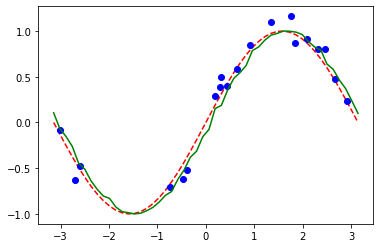

In [42]:
# Plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), 'r--')

# Plot data
plt.plot(X, y, 'bo')

# Plot fitted line
y_ = []
for out in out_tensor:
    y_ += [out.item()]
plt.plot(np.linspace(lb, ub), y_, 'g-')
plt.show()

### `score()` for checking the accuracy.
Call `TorchRuntimeClient`'s `score` method with a data loader for checking the accuracy of the trained model. We can pass a string to `score_func` for the pre-defined score functions (`"Classification"` and `"Regression"`). We can also pass a custom scoring function defined as : `def score_func(model_output, target): -> score: float`. In this example, we use pre-defiend `"Regression"` function.

In [47]:
score = torch_runtime_client.score(data_loader = val_loader, score_func = "Regression")

In [49]:
!docker cp ~/github/torch-runtime/src/torch_infer.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
!docker exec da1e5b452975 /runtime/program_starter.py

/usr/local/lib/python3.8/site-packages/qiskit/opflow/primitive_ops/pauli_sum_op.py:316: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  corrected_x_bits = self.primitive.table.X[::, ::-1]
{"score": 0.0046539699854020004, "prediction": [[[0.0859375]], [[-0.05078125]], [[-0.197265625]], [[-0.24609375]], [[-0.41015625]], [[-0.5546875]], [[-0.63671875]], [[-0.705078125]], [[-0.8203125]], [[-0.859375]], [[-0.921875]], [[-0.97265625]], [[-0.9921875]], [[-1.0]], [[-0.994140625]], [[-0.962890625]], [[-0.921875]], [[-0.8671875]], [[-0.810546875]], [[-0.728515625]], [[-0.58203125]], [[-0.5390625]], [[-0.390625]], [[-0.263671875]], [[-0.15625]], [[0.04296875]], [[0.087890625]], [[0.20703125]], [[0.34375]], [[0.517578125]], [[0.56640625]], [[0.6875]], [[0.720703125]], [[0.818359375]], [[0.91796875]], [[0.9609375]], [[0.974609375]], [[0.998046875]]

In [50]:
result_ = {"score": 0.0046539699854020004, "prediction": [[[0.0859375]], [[-0.05078125]], [[-0.197265625]], [[-0.24609375]], [[-0.41015625]], [[-0.5546875]], [[-0.63671875]], [[-0.705078125]], [[-0.8203125]], [[-0.859375]], [[-0.921875]], [[-0.97265625]], [[-0.9921875]], [[-1.0]], [[-0.994140625]], [[-0.962890625]], [[-0.921875]], [[-0.8671875]], [[-0.810546875]], [[-0.728515625]], [[-0.58203125]], [[-0.5390625]], [[-0.390625]], [[-0.263671875]], [[-0.15625]], [[0.04296875]], [[0.087890625]], [[0.20703125]], [[0.34375]], [[0.517578125]], [[0.56640625]], [[0.6875]], [[0.720703125]], [[0.818359375]], [[0.91796875]], [[0.9609375]], [[0.974609375]], [[0.998046875]], [[1.0]], [[0.986328125]], [[0.939453125]], [[0.921875]], [[0.86328125]], [[0.779296875]], [[0.662109375]], [[0.52734375]], [[0.439453125]], [[0.388671875]], [[0.216796875]], [[0.126953125]]]}

In [52]:
score = result_["score"]
score

0.0046539699854020004

In [119]:
prediction = torch_runtime_client.predict(data_loader = val_loader)

!docker cp ~/github/torch-runtime/src/torch_infer.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
!docker exec da1e5b452975 /runtime/program_starter.py

Traceback (most recent call last):
  File "/runtime/program_starter.py", line 34, in <module>
    main(backend, messenger, **user_params)
  File "/runtime/program.py", line 174, in main
    out = infer.predict()
  File "/runtime/program.py", line 93, in predict
    out = self.model(data)
  File "/usr/local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.8/site-packages/qiskit_machine_learning/connectors/torch_connector.py", line 279, in forward
    return TorchConnector._TorchNNFunction.apply(
  File "/usr/local/lib/python3.8/site-packages/qiskit_machine_learning/connectors/torch_connector.py", line 95, in forward
    raise QiskitMachineLearningError(
qiskit_machine_learning.exceptions.QiskitMachineLearningError: 'Invalid input dimension! Received torch.Size([1, 1]) and expected input compatible to 2'


## 2. Classification

In [107]:
print('Accuracy:', sum(y_predict == y)/len(y))

Accuracy: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## 1. Classification

First, we show how to use Torch Runtime via `TorchRuntimeClient` using the simple classification example. In the example, we will perform binary classification on a randomly generated dataset.

In [1]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor, manual_seed, is_tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, Adam
from torch.utils.data import Dataset, DataLoader

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult


# Set seed for random generators
seed = 42
manual_seed(seed)
algorithm_globals.random_seed = seed

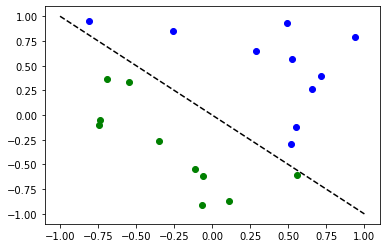

In [2]:
# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2*algorithm_globals.random.random([num_samples, num_inputs]) - 1
y = 2*(np.sum(X, axis=1) >= 0)-1 # in {-1, +1}

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

`TorchRuntimeClient` requires a PyTorch `DataLoader` as an input for training/predicting. For that purpose, we create a custom torch dataset class.

In [3]:
# Create custom torch dataset class
class TorchDataset(Dataset):

    """Map-style dataset"""
    def __init__(self, X, y):
        self.X = Tensor(X)
        self.y = Tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        import torch
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X_i = self.X[idx]
        y_i = self.y[idx]

        # important: the dataset item must be returned as data,target
        return X_i, y_i

In [43]:
y_ = y.reshape(len(y), 1)
train_set = TorchDataset(X,y_)
train_loader = DataLoader(train_set, batch_size=1)

Create a PyTorch model, and set up an optimizer and a loss function as usual.

In [67]:
# Set up QNN
qnn1 = TwoLayerQNN(num_qubits=num_inputs)
print(qnn1.operator)

# create a PyTorch module
initial_weights = 0.1*(2*algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

optimizer = LBFGS(model1.parameters())
loss_func = MSELoss(reduction='sum')

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐»
  q_0: ┤0                         ├»
       │  ZZFeatureMap(x[0],x[1]) │»
  q_1: ┤1                         ├»
       └──────────────────────────┘»
  «     ┌──────────────────────────────────────────────────────────┐
  «q_0: ┤0                                                         ├
  «     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
  «q_1: ┤1                                                         ├
  «     └──────────────────────────────────────────────────────────┘
  )
])
Initial weights:  [-0.02763748 -0.08247002 -0.07639882  0.09237953  0.08171614  0.03994143
 -0.04682601  0.09383528]


In [68]:
# Set up a provider and backend
from qiskit import IBMQ
IBMQ.load_account()
print(IBMQ.providers())

provider = IBMQ.get_provider(project='default') 
backend = provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2021-11-05 17:01:30,193: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-internal', group='trl', project='qiskit')>, <AccountProvider for IBMQ(hub='ibm-q-internal', group='deployed', project='default')>]


Create a Torch Runtime Client instance with the model, the optimizer, and other configurations.

In [69]:
torch_runtime_client = TorchRuntimeClient(
                                        provider=provider,
                                        model=model1,
                                        optimizer=optimizer,
                                        loss_func=loss_func,
                                        epochs=1,
                                        backend=backend,
                                        shots=1024,
                                    )

Call `TorchRuntimeClient`'s `fit` method with a data loader for training.  

In [70]:
result = torch_runtime_client.fit(train_loader = train_loader, seed=seed)

----------------
Following cells are added temporarily since we can not real torch runtime server yet.

In [71]:
import dill
import base64
def obj_to_str(obj) -> str:
    """Encodes any object into a JSON-compatible string using dill. The intermediate
    binary data must be converted to base 64 to be able to decode into utf-8 format."""
    string = base64.b64encode(dill.dumps(obj, byref=False)).decode("utf-8")
    return string

def str_to_obj(string: str):
    """Decodes a previously encoded string using dill (with an intermediate step
    converting the binary data from base 64)."""
    obj = dill.loads(base64.b64decode(string.encode()))
    return obj

In [72]:
# result = torch_runtime_client.fit(train_loader = train_loader, seed=42)
!docker cp ~/github/torch-runtime/src/torch_train.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
#!docker exec da1e5b452975 /runtime/program_starter.py

In [73]:
result_ =  {"model_state_dict": "gASVIwMAAAAAAACMC2NvbGxlY3Rpb25zlIwLT3JkZXJlZERpY3SUk5QpUpQojAZ3ZWlnaHSUjAx0b3JjaC5fdXRpbHOUjBJfcmVidWlsZF90ZW5zb3JfdjKUk5QojA10b3JjaC5zdG9yYWdllIwQX2xvYWRfZnJvbV9ieXRlc5STlEIbAQAAgAKKCmz8nEb5IGqoUBkugAJN6QMugAJ9cQAoWBAAAABwcm90b2NvbF92ZXJzaW9ucQFN6QNYDQAAAGxpdHRsZV9lbmRpYW5xAohYCgAAAHR5cGVfc2l6ZXNxA31xBChYBQAAAHNob3J0cQVLAlgDAAAAaW50cQZLBFgEAAAAbG9uZ3EHSwR1dS6AAihYBwAAAHN0b3JhZ2VxAGN0b3JjaApGbG9hdFN0b3JhZ2UKcQFYDgAAADk0MzE0MzkwODI0NDE2cQJYAwAAAGNwdXEDSwhOdHEEUS6AAl1xAFgOAAAAOTQzMTQzOTA4MjQ0MTZxAWEuCAAAAAAAAAB4jn9Tux9MUz/fhNJnFQNUwYjF02BNd9NUgivTIlsS05SFlFKUSwBLCIWUSwGFlIloAilSlHSUUpSMCF93ZWlnaHRzlGgHKGgKQhsBAACAAooKbPycRvkgaqhQGS6AAk3pAy6AAn1xAChYEAAAAHByb3RvY29sX3ZlcnNpb25xAU3pA1gNAAAAbGl0dGxlX2VuZGlhbnECiFgKAAAAdHlwZV9zaXplc3EDfXEEKFgFAAAAc2hvcnRxBUsCWAMAAABpbnRxBksEWAQAAABsb25ncQdLBHV1LoACKFgHAAAAc3RvcmFnZXEAY3RvcmNoCkZsb2F0U3RvcmFnZQpxAVgOAAAAOTQzMTQzOTA4MjQ0MTZxAlgDAAAAY3B1cQNLCE50cQRRLoACXXEAWA4AAAA5NDMxNDM5MDgyNDQxNnEBYS4IAAAAAAAAAHiOf1O7H0xTP9+E0mcVA1TBiMXTYE1301SCK9MiWxLTlIWUUpRLAEsIhZRLAYWUiWgCKVKUdJRSlHV9lIwJX21ldGFkYXRhlGgCKVKUjACUfZSMB3ZlcnNpb26USwFzc3NiLg==", "train_history": {"train": [{"epoch": 0, "loss": 1.2358922958374023, "forward_time": 0.0, "backward_time": 0.0, "epoch_time": 63.84972834587097}], "validation": []}, "train_time": 63.85001063346863}

In [74]:
torch_runtime_client._model.load_state_dict(str_to_obj(result_["model_state_dict"]))

# re-build result from serialized return value
result = TorchRuntimeResult()
result.job_id = 12345
result.train_history = result_.get("train_history", {}).get("train", None)
result.val_history = result_.get("train_history", {}).get("val", None)
result.model_state_dict = str_to_obj(result_.get("model_state_dict"))
result.train_time = result_.get("train_time")

-------------------

In [75]:
print('id: ', result.job_id)
print('train history: ', result.train_history)
print('validation history: ', result.val_history)
print('train time: ', result.train_time)


id:  12345
train history:  [{'epoch': 0, 'loss': 1.2358922958374023, 'forward_time': 0.0, 'backward_time': 0.0, 'epoch_time': 63.84972834587097}]
validation history:  None
train time:  63.85001063346863


We can also perform validation while training a model by passing a validation data loader to `fit` method.

In [76]:
# Create a data loader for validation
X_test = 2*algorithm_globals.random.random([num_samples, num_inputs]) - 1
y_test = 2*(np.sum(X_test, axis=1) >= 0)-1 # in {-1, +1}

y_test_ = y_test.reshape(len(y_test), 1)
val_set = TorchDataset(X_test,y_test_)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

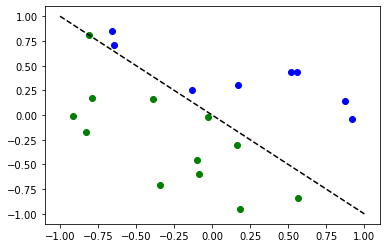

In [77]:
# Plot dataset
for x, y_target in zip(X_test, y_test):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [38]:
torch_runtime_client = TorchRuntimeClient(
                                        provider=provider,
                                        model=model1,
                                        optimizer=optimizer,
                                        loss_func=loss_func,
                                        epochs=1,
                                        backend=backend,
                                        shots=1024,
                                    )

In [29]:
result = torch_runtime_client.fit(train_loader = train_loader, val_loader=val_loader, seed=seed)

In [28]:
# result = torch_runtime_client.fit(train_loader = train_loader, seed=42)
!docker cp ~/github/torch-runtime/src/torch_train.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
#!docker exec da1e5b452975 /runtime/program_starter.py

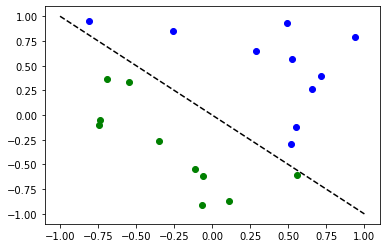

In [46]:
# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [ ]:
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [79]:
prediction = torch_runtime_client.predict(data_loader = train_loader)

!docker cp ~/github/torch-runtime/src/torch_infer.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
!docker exec da1e5b452975 /runtime/program_starter.py

/usr/local/lib/python3.8/site-packages/qiskit/opflow/primitive_ops/pauli_sum_op.py:316: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  corrected_x_bits = self.primitive.table.X[::, ::-1]
{"prediction": [[[-0.248046875]], [[-0.193359375]], [[0.685546875]], [[-0.68359375]], [[0.05078125]], [[-0.35546875]], [[-0.1953125]], [[-0.2734375]], [[-0.05078125]], [[-0.076171875]], [[-0.26953125]], [[-0.810546875]], [[-0.185546875]], [[-0.921875]], [[-0.162109375]], [[-0.880859375]], [[-0.177734375]], [[-0.13671875]], [[0.353515625]], [[0.091796875]]]}


In [81]:
output = {"prediction": [[[-0.248046875]], [[-0.193359375]], [[0.685546875]], [[-0.68359375]], [[0.05078125]], [[-0.35546875]], [[-0.1953125]], [[-0.2734375]], [[-0.05078125]], [[-0.076171875]], [[-0.26953125]], [[-0.810546875]], [[-0.185546875]], [[-0.921875]], [[-0.162109375]], [[-0.880859375]], [[-0.177734375]], [[-0.13671875]], [[0.353515625]], [[0.091796875]]]}

out_tensor = Tensor(output["prediction"])
#out_tensor

In [82]:
y_predict = []
for out in out_tensor:
    #print(np.sign(out.item()))
    y_predict += [np.sign(out.item())]
print(y_predict)


[-1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0]


In [83]:
print('Accuracy:', sum(y_predict == y)/len(y))

Accuracy: 0.4


In [65]:
print('Accuracy:', sum(y_predict == y_test)/len(y_test))

Accuracy: 0.35


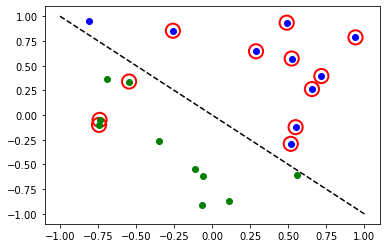

In [84]:
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

In [ ]:
# train_loader5 = DataLoader(train_set, batch_size=5, shuffle=False)
# score = runtime_torch.score(data_loader = train_loader5, score_func = "Regression")
score = runtime_torch.score(data_loader = test_loader, score_func = "Regression")

!docker cp ../src/torch_infer.py da1e5b452975:/runtime/program.py
!docker cp ./params.json da1e5b452975:/runtime/params.json
!docker exec da1e5b452975 /runtime/program_starter.py

/usr/local/lib/python3.8/site-packages/qiskit/opflow/primitive_ops/pauli_sum_op.py:316: DeprecationWarning: The SparsePauliOp.table method is deprecated as of Qiskit Terra 0.19.0 and will be removed no sooner than 3 months after the releasedate. Use SparsePauliOp.paulis method instead.
  corrected_x_bits = self.primitive.table.X[::, ::-1]
{"score": 0.007013784927285088, "prediction": [[[-0.119140625]], [[-0.25]], [[-0.3515625]], [[-0.49609375]], [[-0.59375]], [[-0.642578125]], [[-0.78125]], [[-0.837890625]], [[-0.9140625]], [[-0.9453125]], [[-0.982421875]], [[-0.998046875]], [[-0.998046875]], [[-0.982421875]], [[-0.9296875]], [[-0.90625]], [[-0.806640625]], [[-0.703125]], [[-0.650390625]], [[-0.5859375]], [[-0.4609375]], [[-0.34765625]], [[-0.177734375]], [[-0.052734375]], [[0.0]], [[0.162109375]], [[0.27734375]], [[0.361328125]], [[0.57421875]], [[0.640625]], [[0.6953125]], [[0.830078125]], [[0.892578125]], [[0.921875]], [[0.9609375]], [[0.994140625]], [[1.0]], [[0.99609375]], [[0.958

In [ ]:
result = 

In [26]:
y_ = y.reshape(len(y), 1)
train_set = TorchDataset(X,y_)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)

In [34]:
torch_runtime_client = TorchRuntimeClient(
                                 provider=provider,
                                 model=model1,
                                 optimizer=optimizer,
                                 loss_func=loss_func,
                                 epochs=5,
                                 backend=backend,
                                 shots=1024,
                                 #callback=callback
                                 )

NameError: name 'TorchRuntimeClient' is not defined

In [23]:
is_tensor

<function torch.is_tensor(obj)>

In [19]:
y_ = y.reshape(len(y), 1)

In [20]:
train_set = TorchDataset(X,y_)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False)


In [21]:
for data, target in train_loader:
    print(data, target)

tensor([[-0.1257,  0.6654]]) tensor([[1.]])
tensor([[ 0.4005, -0.3753]]) tensor([[1.]])
tensor([[0.6645, 0.6095]]) tensor([[1.]])
tensor([[-0.2250, -0.4233]]) tensor([[-1.]])
tensor([[ 0.3650, -0.7205]]) tensor([[-1.]])
tensor([[-0.6002, -0.9853]]) tensor([[-1.]])
tensor([[0.5738, 0.3297]]) tensor([[1.]])
tensor([[0.4103, 0.5615]]) tensor([[1.]])
tensor([[-0.0822,  0.1375]]) tensor([[1.]])
tensor([[-0.7204, -0.7709]]) tensor([[-1.]])
tensor([[ 0.3368, -0.0578]]) tensor([[1.]])
tensor([[0.1305, 0.5300]]) tensor([[1.]])
tensor([[0.2694, 0.1072]]) tensor([[1.]])
tensor([[ 0.1184, -0.3921]]) tensor([[-1.]])
tensor([[-0.9384, -0.1266]]) tensor([[-1.]])
tensor([[-0.5708, -0.1829]]) tensor([[-1.]])
tensor([[ 0.7068, -0.5321]]) tensor([[1.]])
tensor([[-0.8834, -0.4372]]) tensor([[-1.]])
tensor([[-0.4128,  0.3238]]) tensor([[-1.]])
tensor([[0.1141, 0.5678]]) tensor([[1.]])


In [8]:

# Convert to torch Tensors
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y_

tensor([[ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]])

In [5]:
y

array([ 1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1,  1, -1,
       -1, -1, -1])

In [9]:
# Create custom torch dataset class

from torch.utils.data import Dataset, DataLoader
from torch import Tensor
import torch

class TorchDataset(Dataset):

    """Map-style dataset"""
    def __init__(self, X, y):
        self.X = Tensor(X)
        self.y = Tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        import torch
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X_i = self.X[idx]
        y_i = self.y[idx]

        # important: the dataset item must be returned as data,target
        return X_i, y_i